In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
# from pmdarima import auto_arima

Step 1: Divide the Dataset into Training and Testing Sets
First, we need to divide the dataset into training and testing sets to evaluate model performance. Let's load the data and split it:

In [3]:
# Fetch the data
tickers = ['TSLA']
start_date = '2015-01-01'
end_date = '2025-01-31'
data = yf.download(tickers, start=start_date, end=end_date)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

[*********************100%***********************]  1 of 1 completed

Training set size: 2028
Testing set size: 507


Step 2: Choose and Train the Model

You can choose between ARIMA, SARIMA, or LSTM models.

1: ARIMA Model

Check the stationary for ARIMA model:

In [6]:
# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(train_data['Close'].diff().dropna())

print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

ADF Statistic: -8.211793027910579
p-value: 6.787401964471895e-13


The Augmented Dickey-Fuller (ADF) test result indicates that the time series is stationary:
Since the p-value is less than 0.05, we reject the null hypothesis that the series has a unit root (i.e., it is non-stationary). This confirms that the differencing operation successfully made the series stationary, which is a good sign.

Optimize Model Parameters 

Get the best order (p, d, q) parameters for ARIMA using AIC, BIC, and cross-validation:

In [11]:
# Function to evaluate ARIMA models with AIC, BIC, and cross-validation
def evaluate_arima_models(train_data):
    results = []
    tscv = TimeSeriesSplit(n_splits=5)

    for p in range(0, 6):
        for d in range(0, 3):
            for q in range(0, 6):
                try:
                    model = ARIMA(train_data['Close'], order=(p, d, q)).fit()
                    aic = model.aic
                    bic = model.bic

                    mae_list = []
                    rmse_list = []

                    for train_index, test_index in tscv.split(train_data['Close']):
                        train_split, test_split = train_data['Close'].iloc[train_index], train_data['Close'].iloc[test_index]
                        cv_model = ARIMA(train_split, order=(p, d, q)).fit()
                        predictions = cv_model.forecast(steps=len(test_split))
                        mae_list.append(mean_absolute_error(test_split, predictions))
                        rmse_list.append(np.sqrt(mean_squared_error(test_split, predictions)))

                    cv_mae = np.mean(mae_list)
                    cv_rmse = np.mean(rmse_list)

                    results.append((p, d, q, aic, bic, cv_mae, cv_rmse))
                except:
                    continue

    results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'AIC', 'BIC', 'CV_MAE', 'CV_RMSE'])
    return results_df

# Evaluate ARIMA models
arima_results = evaluate_arima_models(train_data)
arima_results_sorted = arima_results.sort_values(by=['CV_MAE', 'AIC', 'BIC'])
print(arima_results_sorted.head())

e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.v

     p  d  q           AIC           BIC     CV_MAE    CV_RMSE
83   4  1  5  12636.463887  12692.607009  40.358694  47.043060
101  5  1  5  12621.580478  12683.337912  40.436267  47.140974
95   5  0  5  12668.392481  12735.770145  40.467973  47.311578
100  5  1  4  12636.091604  12692.234725  40.480907  47.171426
82   4  1  4  12632.684224  12683.213034  40.511807  47.240122


Model Selection
Best AIC: Order (5, 1, 5) with AIC of 12621.580478

Best BIC: Order (4, 1, 5) with BIC of 12692.607009

Best Cross-Validation MAE: Order (4, 1, 5) with CV_MAE of 40.358694

Best Cross-Validation RMSE: Order (4, 1, 5) with CV_RMSE of 47.043060

Conclusion:
The model with the order (4, 1, 5) has the best Cross-Validation MAE and RMSE, making it a strong candidate in terms of predictive accuracy. While the order (5, 1, 5) has the lowest AIC, its cross-validated performance is slightly worse. Considering BIC and cross-validation performance, the order (4, 1, 5) seems to offer a good balance between model fit, complexity, and predictive accuracy.

Recommended Model:
Based on the combined criteria of AIC, BIC, and Cross-Validation metrics, the ARIMA model with the order (4, 1, 5) is recommended as it provides a balance of good fit and generalization to unseen data.

Train and Evalute the ARIMA model

In [4]:
# Train the ARIMA model with the best order (4, 1, 5)
best_arima_order = (4, 1, 5)
arima_model = ARIMA(train_data['Close'], order=best_arima_order)
arima_model_fit = arima_model.fit()

# Forecast future stock prices
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Check for NaN values in predictions
print("NaN values in predictions:", arima_predictions.isna().sum())

# Handle NaN values if present
arima_predictions = arima_predictions.fillna(method='bfill').fillna(method='ffill')

# Evaluate model performance
mae = mean_absolute_error(test_data['Close'], arima_predictions)
rmse = np.sqrt(mean_squared_error(test_data['Close'], arima_predictions))
mape = np.mean(np.abs((test_data['Close'] - arima_predictions) / test_data['Close'].replace(0, np.nan))) * 100

print(f"ARIMA MAE: {mae}")
print(f"ARIMA RMSE: {rmse}")
print(f"ARIMA MAPE: {mape}%")

e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


NaN values in predictions: 0
ARIMA MAE: 89.3479373681955
ARIMA RMSE: 110.62049681693644
ARIMA MAPE: nan%


e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Abeni\AppData\Local\Temp\ipykernel_7512\968494179.py:13: FutureWarning: Series.fillna with 'meth

SARIMA Model

In [5]:
# Train the SARIMA model
sarima_model = SARIMAX(train_data['Close'], order=(4, 1, 5), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()

# Forecast future stock prices
sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))

# Evaluate model performance
mae = mean_absolute_error(test_data['Close'], sarima_predictions)
rmse = np.sqrt(mean_squared_error(test_data['Close'], sarima_predictions))
mape = np.mean(np.abs((test_data['Close'] - sarima_predictions) / test_data['Close'])) * 100

print(f"SARIMA MAE: {mae}")
print(f"SARIMA RMSE: {rmse}")
print(f"SARIMA MAPE: {mape}%")

e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.ven

SARIMA MAE: 75.55893471402551
SARIMA RMSE: 97.08877953059982
SARIMA MAPE: nan%


e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


LSTM Model

e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1967/1967 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - loss: 0.0030
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
LSTM MAE: 17.514469146728516
LSTM RMSE: 21.61986044077333
LSTM MAPE: 7.456858828598675%


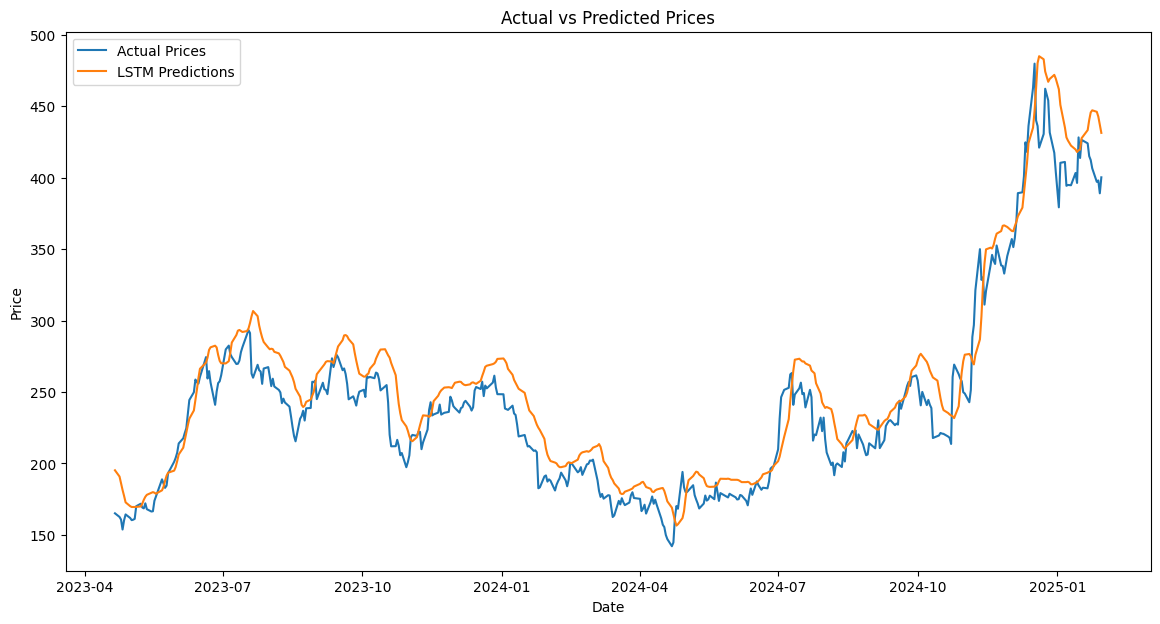

In [6]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))

# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, Y_train = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Create the LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile and train the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Prepare the test data
test_data_scaled = scaler.transform(test_data['Close'].values.reshape(-1, 1))
X_test, Y_test = create_dataset(test_data_scaled, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Predict future stock prices
lstm_predictions_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Evaluate model performance
mae = mean_absolute_error(test_data['Close'][time_step + 1:], lstm_predictions)
rmse = np.sqrt(mean_squared_error(test_data['Close'][time_step + 1:], lstm_predictions))
mape = np.mean(np.abs((test_data['Close'][time_step + 1:] - lstm_predictions) / test_data['Close'][time_step + 1:])) * 100

print(f"LSTM MAE: {mae}")
print(f"LSTM RMSE: {rmse}")
print(f"LSTM MAPE: {mape}%")

plt.figure(figsize=(14, 7))
plt.plot(test_data['Close'][time_step + 1:].index, test_data['Close'][time_step + 1:], label='Actual Prices')
plt.plot(test_data['Close'][time_step + 1:].index, lstm_predictions, label='LSTM Predictions')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


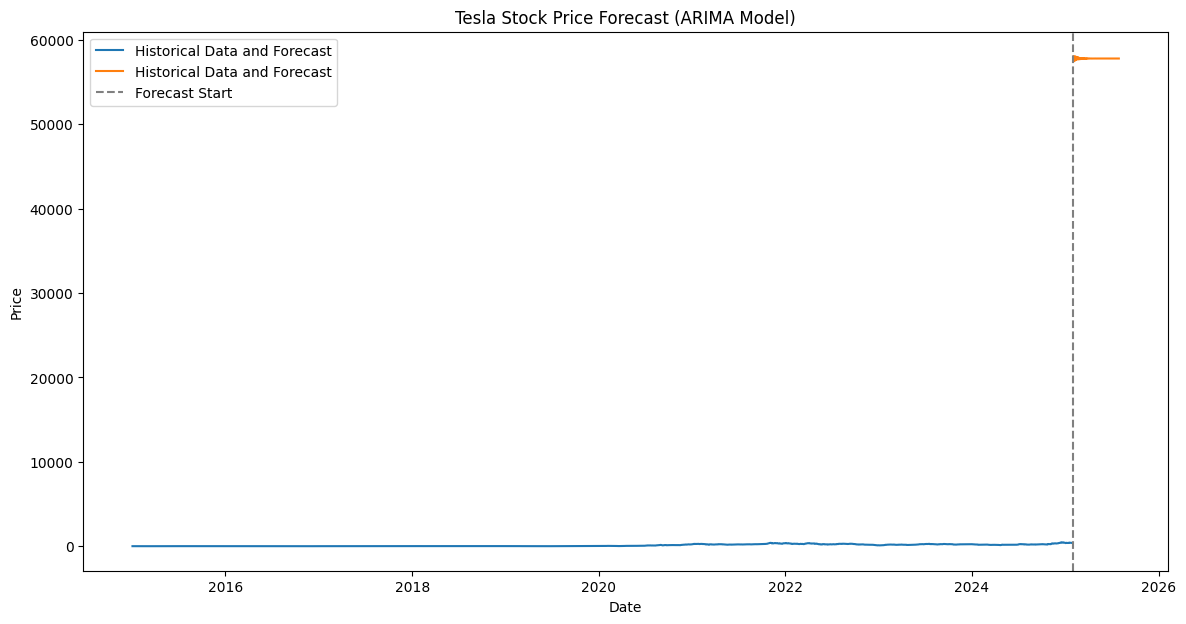

In [9]:
# Extend the forecast horizon to 6-12 months (e.g., 180 days)
forecast_period = 180
arima_forecast = arima_model_fit.forecast(steps=forecast_period)

# Convert the forecast to a NumPy array and reshape for inverse transformation
arima_forecast = scaler.inverse_transform(arima_forecast.to_numpy().reshape(-1, 1))

# Create a DataFrame for the forecasted values with corresponding dates
forecast_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=forecast_period)
arima_forecast_df = pd.DataFrame(arima_forecast, index=forecast_dates, columns=['Forecast'])

# Combine historical data with forecast
combined_data = pd.concat([data['Close'], arima_forecast_df])

# Plot the historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(combined_data, label='Historical Data and Forecast')
plt.axvline(x=test_data.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title('Tesla Stock Price Forecast (ARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


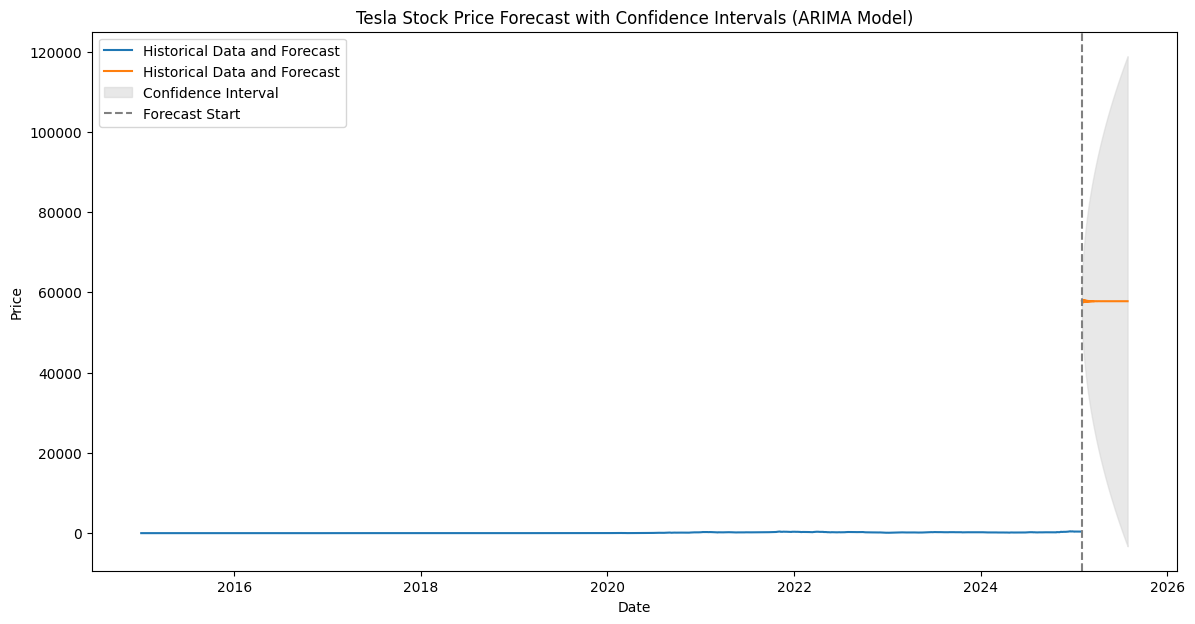

In [10]:
# Get confidence intervals for the forecast
forecast_result = arima_model_fit.get_forecast(steps=forecast_period)
confidence_intervals = forecast_result.conf_int()

# Inverse transform the confidence intervals
confidence_intervals_transformed = scaler.inverse_transform(confidence_intervals)

# Plot the forecast with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(combined_data, label='Historical Data and Forecast')
plt.fill_between(forecast_dates, confidence_intervals_transformed[:, 0], confidence_intervals_transformed[:, 1], color='lightgray', alpha=0.5, label='Confidence Interval')
plt.axvline(x=test_data.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title('Tesla Stock Price Forecast with Confidence Intervals (ARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [11]:
# Normalize the data again
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create a new sequence for future predictions
forecast_horizon = 180
lstm_input = scaled_data[-time_step:]
lstm_forecast = []

for _ in range(forecast_horizon):
    lstm_input = lstm_input.reshape((1, time_step, 1))
    predicted_price = lstm_model.predict(lstm_input)
    lstm_forecast.append(predicted_price[0, 0])
    lstm_input = np.append(lstm_input[:, 1:, :], [[predicted_price]], axis=1)

# Inverse transform the forecasted values
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1))

# Create a DataFrame for the forecasted values with corresponding dates
forecast_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
lstm_forecast_df = pd.DataFrame(lstm_forecast, index=forecast_dates, columns=['Forecast'])

# Combine historical data with forecast
combined_data = pd.concat([data['Close'], lstm_forecast_df])

# Plot the historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(combined_data, label='Historical Data and Forecast')
plt.axvline(x=test_data.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title('Tesla Stock Price Forecast (LSTM Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [13]:
# Normalize the data again
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create a new sequence for future predictions
forecast_horizon = 180
lstm_input = scaled_data[-time_step:]
lstm_forecast = []

for _ in range(forecast_horizon):
    lstm_input = lstm_input.reshape((1, time_step, 1))
    predicted_price = lstm_model.predict(lstm_input)
    lstm_forecast.append(predicted_price[0, 0])
    lstm_input = np.append(lstm_input[:, 1:, :], [[predicted_price]], axis=1)

# Inverse transform the forecasted values
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1))

# Create a DataFrame for the forecasted values with corresponding dates
forecast_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
lstm_forecast_df = pd.DataFrame(lstm_forecast, index=forecast_dates, columns=['Forecast'])

# Combine historical data with forecast
combined_data = pd.concat([data['Close'], lstm_forecast_df])

# Plot the historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(combined_data, label='Historical Data and Forecast')
plt.axvline(x=test_data.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title('Tesla Stock Price Forecast (LSTM Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

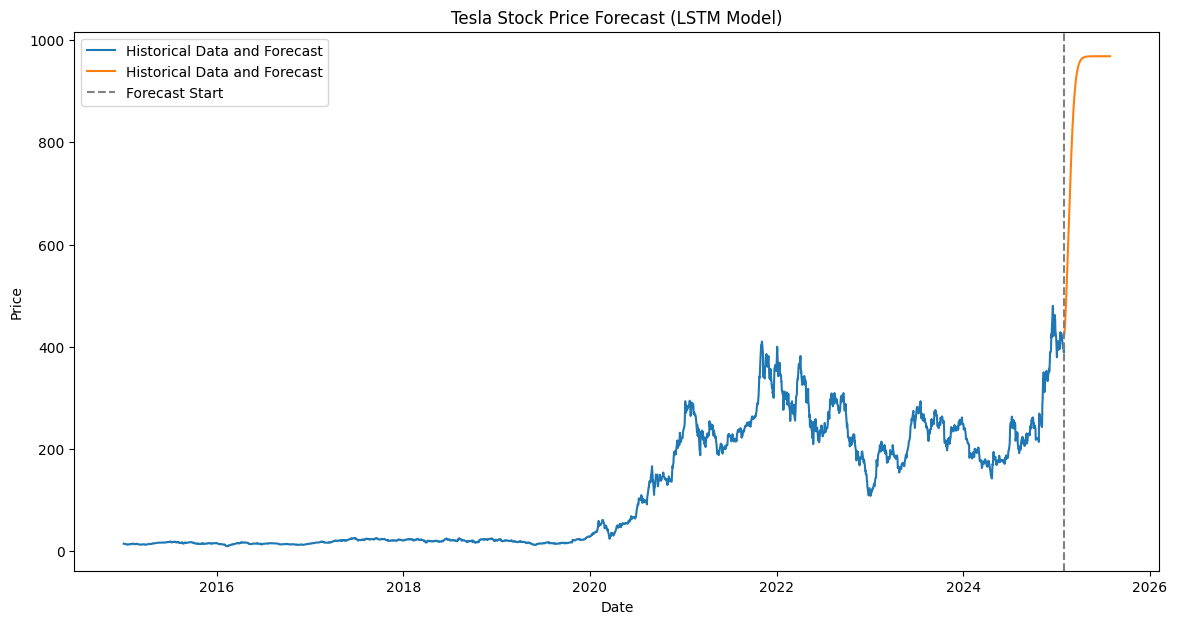

In [14]:
# Normalize the data again
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create a new sequence for future predictions
forecast_horizon = 180
lstm_input = scaled_data[-time_step:]
lstm_forecast = []

for _ in range(forecast_horizon):
    lstm_input = lstm_input.reshape((1, time_step, 1))
    predicted_price = lstm_model.predict(lstm_input)
    lstm_forecast.append(predicted_price[0, 0])
    lstm_input = np.append(lstm_input[:, 1:, :], [[predicted_price[0]]], axis=1)

# Inverse transform the forecasted values
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1))

# Create a DataFrame for the forecasted values with corresponding dates
forecast_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
lstm_forecast_df = pd.DataFrame(lstm_forecast, index=forecast_dates, columns=['Forecast'])

# Combine historical data with forecast
combined_data = pd.concat([data['Close'], lstm_forecast_df])

# Plot the historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(combined_data, label='Historical Data and Forecast')
plt.axvline(x=test_data.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title('Tesla Stock Price Forecast (LSTM Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()